<h1>
<center>Timing Model</center>
</h1>

# Packages and Data

In [1]:
import pandas as pd
import numpy as np
import yfinance as yahooFinance
from yahoofinancials import YahooFinancials
from fredapi import Fred
import datetime as datetime
import matplotlib.pyplot as plt

We first import the close prices of ETFs for each sector.

In [2]:
def import_fin(ticker):
    data = pd.DataFrame(YahooFinancials(ticker).get_historical_price_data(start_date='1901-01-01',
                                                                    end_date='2022-06-30',
                                                                    time_interval='daily')[ticker]['prices']).drop('date', axis=1).set_index('formatted_date')
    price = data['close']
    price.index = pd.to_datetime(price.index)
    
    return price

vnq = import_fin("VNQ")
xlk = import_fin("XLK")
xlf = import_fin("XLF")
xlv = import_fin("XLV")
xle = import_fin("XLE")
xly = import_fin("XLY")
xli = import_fin("XLI")
xlc = import_fin("XLC")
xlp = import_fin("XLP")
xlu = import_fin("XLU")
xlb = import_fin("XLB")

Also, we will only make the decision at the end of each month. So, the following function will extract the data only the the end of each month.

In [3]:
def extract(months):
  ind = []
  for i in range(1,len(months)):
    if months[i-1] != months[i]:
      ind.append(i-1)
  ind = np.array(ind)
  return ind

Now, we can extract the prices at the end of each month as shown below.

In [4]:
ETF_list = [vnq,xlk,xlf,xlv,xle,xly,xli,xlc,xlp,xlu,xlb]
ETF = []
for i in range(len(ETF_list)):
    ETF.append(ETF_list[i][extract(ETF_list[i].index.month)])

name_list = ["vnq", "xlk","xlf", "xlv", "xle", "xly", "xli", "xlc", "xlp", "xlu", "xlb"]
table1 = pd.DataFrame(ETF).T
table1.columns = [k.upper() for k in name_list]
table1

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1998-12-31,NaN,32.625000,19.039398,26.000000,23.343750,26.125000,24.562500,NaN,27.156250,30.234375,21.921875
1999-01-29,NaN,37.812500,19.369415,27.250000,21.812500,27.468750,24.296875,NaN,26.796875,29.484375,21.109375
1999-02-26,NaN,34.062500,19.674046,27.281250,21.625000,27.296875,24.515625,NaN,26.515625,28.671875,21.437500
1999-03-31,NaN,36.593750,20.257919,28.000000,24.593750,28.593750,24.937500,NaN,26.437500,26.687500,21.750000
1999-04-30,NaN,36.812500,21.679529,29.000000,28.234375,29.343750,28.687500,NaN,25.515625,29.265625,27.125000
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,106.239998,161.970001,39.060001,131.229996,65.919998,184.949997,100.739998,73.949997,75.970001,69.250000,84.449997
2022-02-28,102.540001,154.070007,38.520000,129.960007,70.580002,177.429993,99.889999,68.449997,74.900002,67.930000,83.379997
2022-03-31,108.370003,158.929993,38.320000,136.990005,76.440002,185.000000,102.980003,68.779999,75.889999,74.459999,88.150002


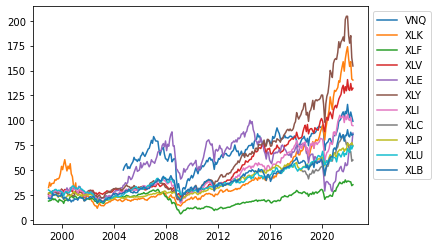

In [5]:
for i in range(11):
    plt.plot(table1.T.iloc[i], label = table1.T.index[i])

plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

Now, the timeing model can be computed using the following function.

In [6]:
def timing(stock, stock_sma, cash):
    port = np.zeros(len(stock))
    port[0] = 100
    stock_status = True
    stock_ret = np.diff(stock)/stock[:-1]
    a = 30
    for i in range(1,len(stock)):
        if (stock[i] >= stock_sma[i]) and stock_status: #stock to stock
            port[i] = port[i-1]*(1+stock_ret[i-1])
        elif (stock[i] >= stock_sma[i]) and ~stock_status: #cash to stock
            port[i] = port[i-1]*(1+stock_ret[i-1])
            stock_status = True
        elif (stock[i] < stock_sma[i]) and stock_status: #stock to cash
            R = cash.iloc[i-1]
            port[i] = port[i-1]*(1+R/12)
            stock_status = False
        elif (stock[i] < stock_sma[i]) and ~stock_status: #cash to cash
            port[i] = port[i-1]*(1+R/12)
        else:
            print(i)

    port = pd.DataFrame(port).squeeze()        
    port.index = stock.index
    
    return port

The main idea of the timing model is the moving average. The following script will be used to compute the moving average.

In [7]:
table = pd.DataFrame(ETF_list).T
table.columns = [k.upper() for k in name_list]

#returns_all = pd.DataFrame.diff(table)/table.shift()
#returns_all

Mean = table.rolling(200).mean()
start_date = Mean.index[200:]
Mean = Mean.loc[start_date]
Mean = Mean.iloc[extract(xlk['1999-10-08':].index.month)]
Mean

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1999-10-29,NaN,38.674141,19.974170,28.101953,26.662734,28.013125,27.710313,NaN,25.465547,29.416250,24.449297
1999-11-30,NaN,39.672109,20.163041,28.266328,27.194219,28.165078,28.106875,NaN,25.337187,29.417031,24.750156
1999-12-31,NaN,41.465000,20.066321,28.497266,27.643438,28.329453,28.459922,NaN,24.963984,29.437500,25.150391
2000-01-31,NaN,42.966875,19.824584,28.735391,27.901641,28.332656,28.721328,NaN,24.607969,29.374531,25.443359
2000-02-29,NaN,44.687500,19.400767,28.762109,27.749766,28.008828,28.441484,NaN,24.193125,29.024687,24.991484
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,105.77675,154.730100,38.128850,130.190400,53.927750,186.308550,103.248100,79.59565,71.891700,66.918000,85.066750
2022-02-28,106.36665,156.418850,38.446750,130.926600,55.665150,186.821200,103.001200,78.93160,72.439500,67.018600,85.014700
2022-03-31,106.83370,158.005300,38.480350,132.085350,58.108850,187.464950,102.675100,77.63890,72.826250,67.671700,84.787450


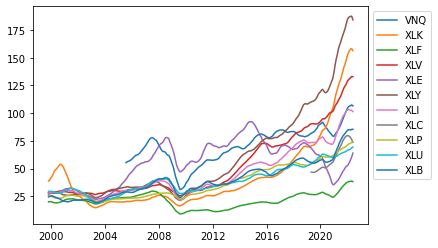

In [8]:
for i in range(11):
    plt.plot(Mean.T.iloc[i], label = Mean.T.index[i])

plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

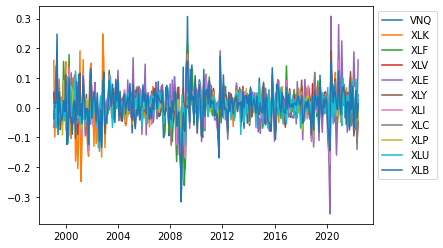

In [9]:
returns = pd.DataFrame.diff(table1)/table1.shift()
returns
for i in range(11):
    plt.plot(returns.T.iloc[i], label = returns.T.index[i])

plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

We would like to know the dynamic of switching between ETF and cash. The following graph illustrates how the dynamic went over the time horizon.

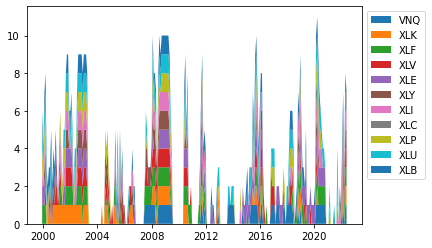

In [10]:
ind = (table1['1999-11-30':]<Mean['1999-11-30':])*1

plt.stackplot(ind.index, ind.T.iloc[0], ind.T.iloc[1], ind.T.iloc[2],ind.T.iloc[3],ind.T.iloc[4],ind.T.iloc[5],ind.T.iloc[6],
             ind.T.iloc[7],ind.T.iloc[8],ind.T.iloc[9],ind.T.iloc[10], labels = ind.T.index)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

We also need a risk-free rate, in which we will use 3-month treasury bill in this case.

In [11]:
fred = Fred(api_key='fec003d5c966f4c13258c8476a6b4dba')
tbill3mo = fred.get_series('DGS3MO').dropna()/100/365
tbill3mo

1981-09-01    0.000466
1981-09-02    0.000456
1981-09-03    0.000465
1981-09-04    0.000456
1981-09-08    0.000453
                ...   
2022-08-12    0.000072
2022-08-15    0.000075
2022-08-16    0.000074
2022-08-17    0.000073
2022-08-18    0.000074
Length: 10242, dtype: float64

In [12]:
rf = tbill3mo[Mean.index]
rf

formatted_date
1999-10-29    0.000140
1999-11-30    0.000145
1999-12-31    0.000146
2000-01-31    0.000158
2000-02-29    0.000158
                ...   
2022-01-31    0.000006
2022-02-28    0.000010
2022-03-31    0.000014
2022-04-29    0.000023
2022-05-31    0.000032
Length: 272, dtype: float64

Now, we will apply the timing model for each ETF given that we start will $100.

In [13]:
port = []
for i in range(len(ETF_list)):
    m = Mean.T.iloc[i]
    m = m[~np.isnan(m)]
    t = table1.T.iloc[i]
    t = t[~np.isnan(t)]
    date = m.index.intersection(t.index)
    m = m[date]
    t = t[date]
    rf2 = rf[date]
    port.append(timing(t, m, rf2))

port = pd.DataFrame(port).T
port.columns = [k.upper() for k in name_list]
port   

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1999-10-29,NaN,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,NaN,100.000000,100.000000,100.000000
1999-11-30,NaN,109.816176,100.001169,101.164725,100.001169,100.055036,100.001169,NaN,100.001169,100.001169,100.001169
1999-12-31,NaN,126.764706,100.002338,109.650582,100.002338,109.411117,107.671713,NaN,100.002338,100.002338,111.105152
2000-01-31,NaN,118.970588,100.003507,106.877427,100.003507,109.412449,107.673023,NaN,100.003507,100.003507,111.106504
2000-02-29,NaN,131.470588,100.004676,106.878832,100.004676,109.413780,107.674334,NaN,100.004676,100.004676,111.107857
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,1150.096620,8786.641035,2957.020871,2203.229281,7180.052230,6613.454813,3841.613175,171.955790,1586.282150,1601.424691,4392.560785
2022-02-28,1150.097198,8786.645448,2916.140331,2203.230387,7687.623083,6613.455719,3841.613701,171.955810,1563.940155,1570.899347,4392.561387
2022-03-31,1215.486984,9063.811452,2916.142661,2322.410952,8325.898441,6613.456625,3960.450438,171.955830,1584.611682,1721.907307,4643.851112


Next, we form an equally weighted portfolio from what we have above.

In [14]:
port1 = np.mean(port.T)
port1

/Users/tingting/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


formatted_date
1999-10-29     100.000000
1999-11-30     101.226995
1999-12-31     107.179180
2000-01-31     106.006002
2000-02-29     107.396010
                 ...     
2022-01-31    3680.393767
2022-02-28    3718.014779
2022-03-31    3867.271226
2022-04-29    3851.094908
2022-05-31    3975.816270
Length: 272, dtype: float64

The following shows how the benchmark is.

In [15]:
bnch = table1['1999-10-29':]/table1['1999-10-29':].iloc[0]*100
bnch

,VNQ,XLK,XLF,XLV,XLE,XLY,XLI,XLC,XLP,XLU,XLB
formatted_date,,,,,,,,,,,
1999-10-29,NaN,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,NaN,100.000000,100.000000,100.000000
1999-11-30,NaN,109.816176,95.599024,101.164725,99.826590,100.055036,97.777778,NaN,100.314663,96.711900,98.583387
1999-12-31,NaN,126.764706,92.970656,109.650582,100.231214,109.411117,105.277778,NaN,92.762744,93.997912,109.529942
2000-01-31,NaN,118.970588,90.220043,106.877427,101.040462,95.817281,96.666667,NaN,93.580868,92.327766,96.136510
2000-02-29,NaN,131.470588,80.562341,99.889074,96.763006,90.478811,91.333333,NaN,82.630585,81.106472,86.477785
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,NaN,381.105885,188.099208,465.819175,243.865889,651.447430,358.186659,NaN,305.983642,231.315240,348.023168
2022-02-28,NaN,362.517664,185.498754,461.311172,261.105209,624.959798,355.164442,NaN,301.674015,226.906055,343.613640
2022-03-31,NaN,373.952924,184.535621,486.265133,282.783824,651.623555,366.151123,NaN,305.661420,248.718160,363.271095


Then we form a benchmark portfolio.

In [16]:
bnch1 = np.mean(bnch.T)
bnch1

/Users/tingting/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


formatted_date
1999-10-29    100.000000
1999-11-30     99.983253
1999-12-31    104.510739
2000-01-31     99.070846
2000-02-29     93.412444
                 ...    
2022-01-31    352.649589
2022-02-28    346.972306
2022-03-31    362.551428
2022-04-29    339.174843
2022-05-31    341.894021
Length: 272, dtype: float64

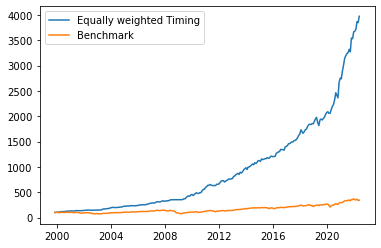

In [17]:
plt.plot(port1)
plt.plot(bnch1)
plt.legend(["Equally weighted Timing","Benchmark"])
plt.show()

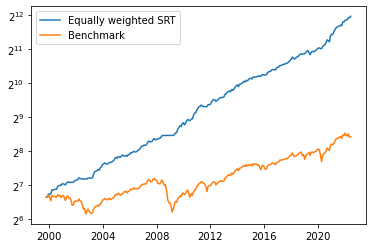

In [18]:
plt.plot(port1)
plt.plot(bnch1)
plt.legend(["Equally weighted SRT","Benchmark"])
plt.yscale('log',base=2)
plt.show()

## Performance

In [19]:
ret_port = np.diff(port1)/port1[:-1]
ret_bnch = np.diff(bnch1)/bnch1[:-1]

In [20]:
print(np.mean(ret_port), np.mean(ret_bnch))

0.013955136397666672 0.00545366605834432


The average return is 1.39% compared to the benchmark of 0.54%.

In [21]:
print(np.std(ret_port), np.std(ret_bnch))

0.02364492315796882 0.042292761894572276


The standard deviation is 0.023 compared to 0.042 benchmark.

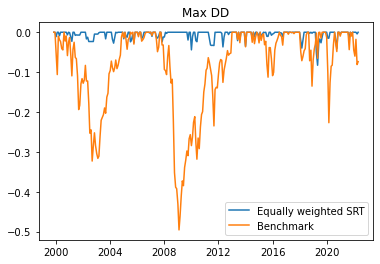

In [22]:
def DD(ret):
  dd = np.zeros(len(ret))
  dd[0] = 0
  for i in range(1,len(ret)):
    dd[i] = min(0,(1+dd[i-1])*(1+ret[i])-1)

  dd = pd.DataFrame(dd).squeeze()
  dd.index = ret.index
  return dd

plt.plot(DD(np.diff(port1)/port1[:-1]), label='Equally weighted SRT')
plt.plot(DD(np.diff(bnch1)/bnch1[:-1]), label='Benchmark')
plt.legend()
plt.title("Max DD")
plt.show()

In [23]:
print(np.min(DD(ret_port)), np.min(DD(ret_bnch)))

-0.08282572332178606 -0.4958796571634596


The maximum drawdown is also low, 8.28% compared to benckmark of 49.58%.

In [24]:
sharpe_port = np.mean(ret_port-rf) / np.std(ret_port-rf)
sharpe_bnch = np.mean(ret_bnch-rf) / np.std(ret_bnch-rf)

print(sharpe_port,sharpe_bnch)

0.5883111163314382 0.1279321715580487


The sharpe ratio of the portfolio is 0.59, which way outperforms the benchmark of 0.13.

We can also compute information ratio.

In [25]:
info = np.mean(ret_port-ret_bnch)/np.std(ret_port-ret_bnch)
info

0.2831621280171129

In [26]:
cal_port = -np.mean(ret_port-rf)/np.min(DD(ret_port))
cal_bnch = -np.mean(ret_bnch-rf)/np.min(DD(ret_bnch))
print(cal_port,cal_bnch)

0.16797376176166587 0.010912078968154378


The Clamar ratios of the portfolio and the benchmark are 0.08 and 0.008, respectively.